# WIP
To get the transfer data of the token, download it from solscan

To get the marketcap and holders data, use get_mkcap_data.ipynb and get_top_holders_data.ipynb

The default data is from the token [7DfbAm1DkkUZtMqrT9mNWTyEuvah4aH6SvaPsKLspump](https://solscan.io/token/7DfbAm1DkkUZtMqrT9mNWTyEuvah4aH6SvaPsKLspump)

In [ ]:
!pip install matplotlib pandas dotenv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import date_range

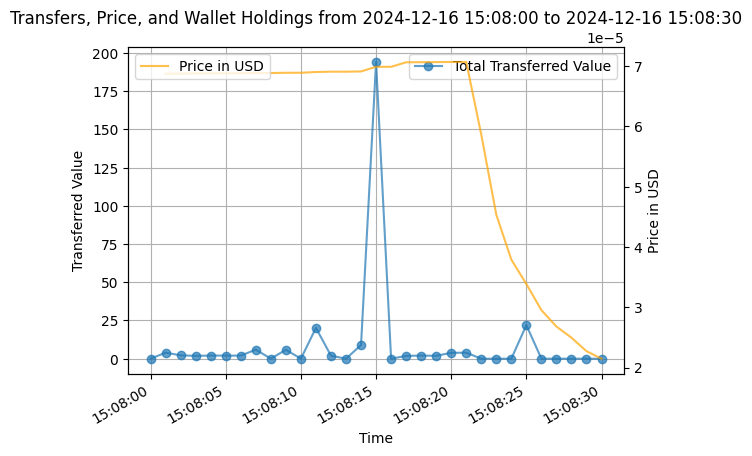

In [ ]:
# Load the two datasets
price_data = pd.read_csv("price_data.csv")
transfer_data = pd.read_csv("filtered_transfer_data.csv")
holders_data = pd.read_csv("holders_data.csv")

# Define the time range
time_start = "2024-12-16 15:08:00"
time_end = "2024-12-16 15:08:30"

# Convert Time columns to datetime format
price_data['Time'] = pd.to_datetime(price_data['Time'], utc=True)
transfer_data['Time'] = pd.to_datetime(transfer_data['Time'], unit='s', origin='unix', utc=True)
holders_data['Time'] = pd.to_datetime(holders_data['Time'], utc=True)

# Filter data based on the time range
filtered_transfers = transfer_data[
    (transfer_data['Time'] >= time_start) &
    (transfer_data['Time'] <= time_end)
]

filtered_prices = price_data[
    (price_data['Time'] >= time_start) &
    (price_data['Time'] <= time_end)
]

filtered_holders = holders_data[
    (holders_data['Time'] >= time_start) &
    (holders_data['Time'] <= time_end)
]

# Group and aggregate transfer data, price data, and holders data
transfer_summary = filtered_transfers.groupby(filtered_transfers['Time']).agg({'Amount': 'sum', 'Value': 'sum'})
price_summary = filtered_prices.groupby(filtered_prices['Time']).agg({'PriceInUSD': 'mean'})
holder_summary = filtered_holders.groupby(filtered_holders['Time']).agg({'Holding': 'mean'})

# Generate a full time range with 250ms intervals
time_range = date_range(start=time_start, end=time_end, freq='1s', tz='UTC')

# Ensure both datasets cover the full range
transfer_summary = transfer_summary.reindex(time_range, fill_value=0)
price_summary = price_summary.reindex(time_range, method='ffill')

# Remove the pool address from the holders data
filtered_holders = filtered_holders[filtered_holders['Address'] != '5tvFqz38wxL9BWhTo64TQ7mY6sKfQfV7PDcWy2DLwUCN']

# Remove duplicates by aggregating the data
filtered_holders = filtered_holders.groupby(['Time', 'Address']).agg({'Holding': 'mean'}).reset_index()

# Pivot holders data to have one column per wallet address
holders_pivot = filtered_holders.pivot(index='Time', columns='Address', values='Holding')

# Reindex to ensure the data covers the full time range
holders_pivot = holders_pivot.reindex(time_range, method='ffill')

# Plot the data
fig, ax1 = plt.subplots()

# Plot transfer summary
ax1.plot(transfer_summary.index, transfer_summary['Value'], marker='o', linestyle='-', alpha=0.7, label='Total Transferred Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Transferred Value')
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc='upper right')

# Plot price summary
ax2 = ax1.twinx()
ax2.plot(price_summary.index, price_summary['PriceInUSD'], linestyle='-', alpha=0.7, color='orange', label='Price in USD')
ax2.set_ylabel('Price in USD')
ax2.legend(loc='upper left')

fig.autofmt_xdate()

# Adjust title and layout
plt.title(f"Transfers, Price, and Wallet Holdings from {time_start} to {time_end}")
plt.show()
